In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure  prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
!pip install yfinance

In [ ]:
!pip install MiniSom

#Part I: Features Engineering

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# import os
# import time
# import datetime
import numpy as np
import pandas as pd
from pathlib import Path
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
import yfinance as yf
from pandas_datareader.famafrench import get_available_datasets
from pandas import Series, DataFrame

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error,r2_score, median_absolute_error, classification_report, confusion_matrix
# from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
# SOM
from minisom import MiniSom

# Visualization library
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
from matplotlib.patches import Patch
%matplotlib inline

import seaborn as sn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense,LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import talib
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [ ]:

# data=pd.read_csv('./sample_data/AAPL.csv')

data_GOOGL = yf.download('GOOGL', start='2000-01-01' , end='2019-12-31', progress=False)
# data_AAPL = yf.download('AAPL', start='2000-01-01' , end='2019-12-31', progress=False)
data = data_GOOGL
print(data.head(5))
title = data.columns
print(title)

In [ ]:
#Momentum Indicators
data["RSI-9"] = talib.RSI(data["Close"], timeperiod=9)
#Stochastic K
data["STOCH-slowk"],data["STOCH-slowd"] = talib.STOCH(data["High"],data["Low"],data["Close"], fastk_period=2,
                            slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data["MACD"], data["MACD-signal"], data["MACD-hist"] = talib.MACD(data['Close'],fastperiod=2,
                                                                  slowperiod=3, signalperiod=8)
# data = data.drop('macd_hist',axis=1)
data['CCI-9'] = talib.CCI(data["High"],data["Low"],data["Close"], timeperiod=9)
data['MOM-9'] = talib.MOM(data["Close"], timeperiod=9)
#Overlap Studies
#Bollinger Bands
data["BBANDS-upperband-10"],data["BBANDS-middleband-10"],data["BBANDS-lowerband-10"] = talib.BBANDS(data["Close"], timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
data["MA-5"] = talib.MA(data["Close"], timeperiod=5)
data['EMA-5'] = talib.EMA(data["Close"], timeperiod=5)
data['SMA-5'] = talib.SMA(data["Close"], timeperiod=5)
data['WMA-5'] = talib.WMA(data["Close"], timeperiod=5)
data["MA-10"] = talib.MA(data["Close"], timeperiod=10)
data['EMA-10'] = talib.EMA(data["Close"], timeperiod=10)
data['SMA-10'] = talib.SMA(data["Close"], timeperiod=10)
data['WMA-10'] = talib.WMA(data["Close"], timeperiod=10)
#Volatility Indicators
data['ATR-9'] = talib.ATR(data["High"],data["Low"],data["Close"], timeperiod=9)
data['NATR-9'] = talib.NATR(data["High"],data["Low"],data["Close"], timeperiod=9)
data['TR'] = talib.TRANGE(data["High"],data["Low"],data["Close"])
#Volume Indicators
#Acc/Dist
data['AD'] = talib.AD(data["High"],data["Low"],data["Close"], data["Volume"])
#On Balance Volume
data['OBV'] = talib.OBV(data["Close"], data["Volume"])


X_feature = data
# .iloc[:,6:]
# print(X_feature.columns)
print(X_feature.shape)
y = data[['Close']]
print(y.shape)

X_feature[['Close']] = y
X = X_feature.dropna()
print("X:",X.shape)
print("X 10:",X.head(10))


(3868, 43)
(3868, 1)
X: (3859, 43)
X 10:                  Open       High        Low  ...      EMA-5      SMA-5      WMA-5
Date                                         ...                                 
2004-09-01  51.401402  51.536537  49.884884  ...  51.450294  51.920921  51.283617
2004-09-02  49.644646  51.236237  49.519520  ...  51.235464  51.280280  50.911912
2004-09-03  50.525524  50.920921  49.709709  ...  50.841994  50.665665  50.503503
2004-09-07  50.555557  51.051052  49.854855  ...  50.841609  50.622622  50.561894
2004-09-08  50.420422  51.566566  50.300301  ...  50.961474  50.615615  50.754754
2004-09-09  51.316315  51.406406  50.550552  ...  51.043052  50.821822  50.951618
2004-09-10  50.850849  53.333332  50.700703  ...  51.601273  51.204204  51.583583
2004-09-13  53.368366  54.259258  53.283283  ...  52.335450  51.953954  52.450116
2004-09-14  53.778778  56.056057  53.448448  ...  53.490566  52.945946  53.732398
2004-09-15  55.335335  57.172173  55.155155  ...  54.3457

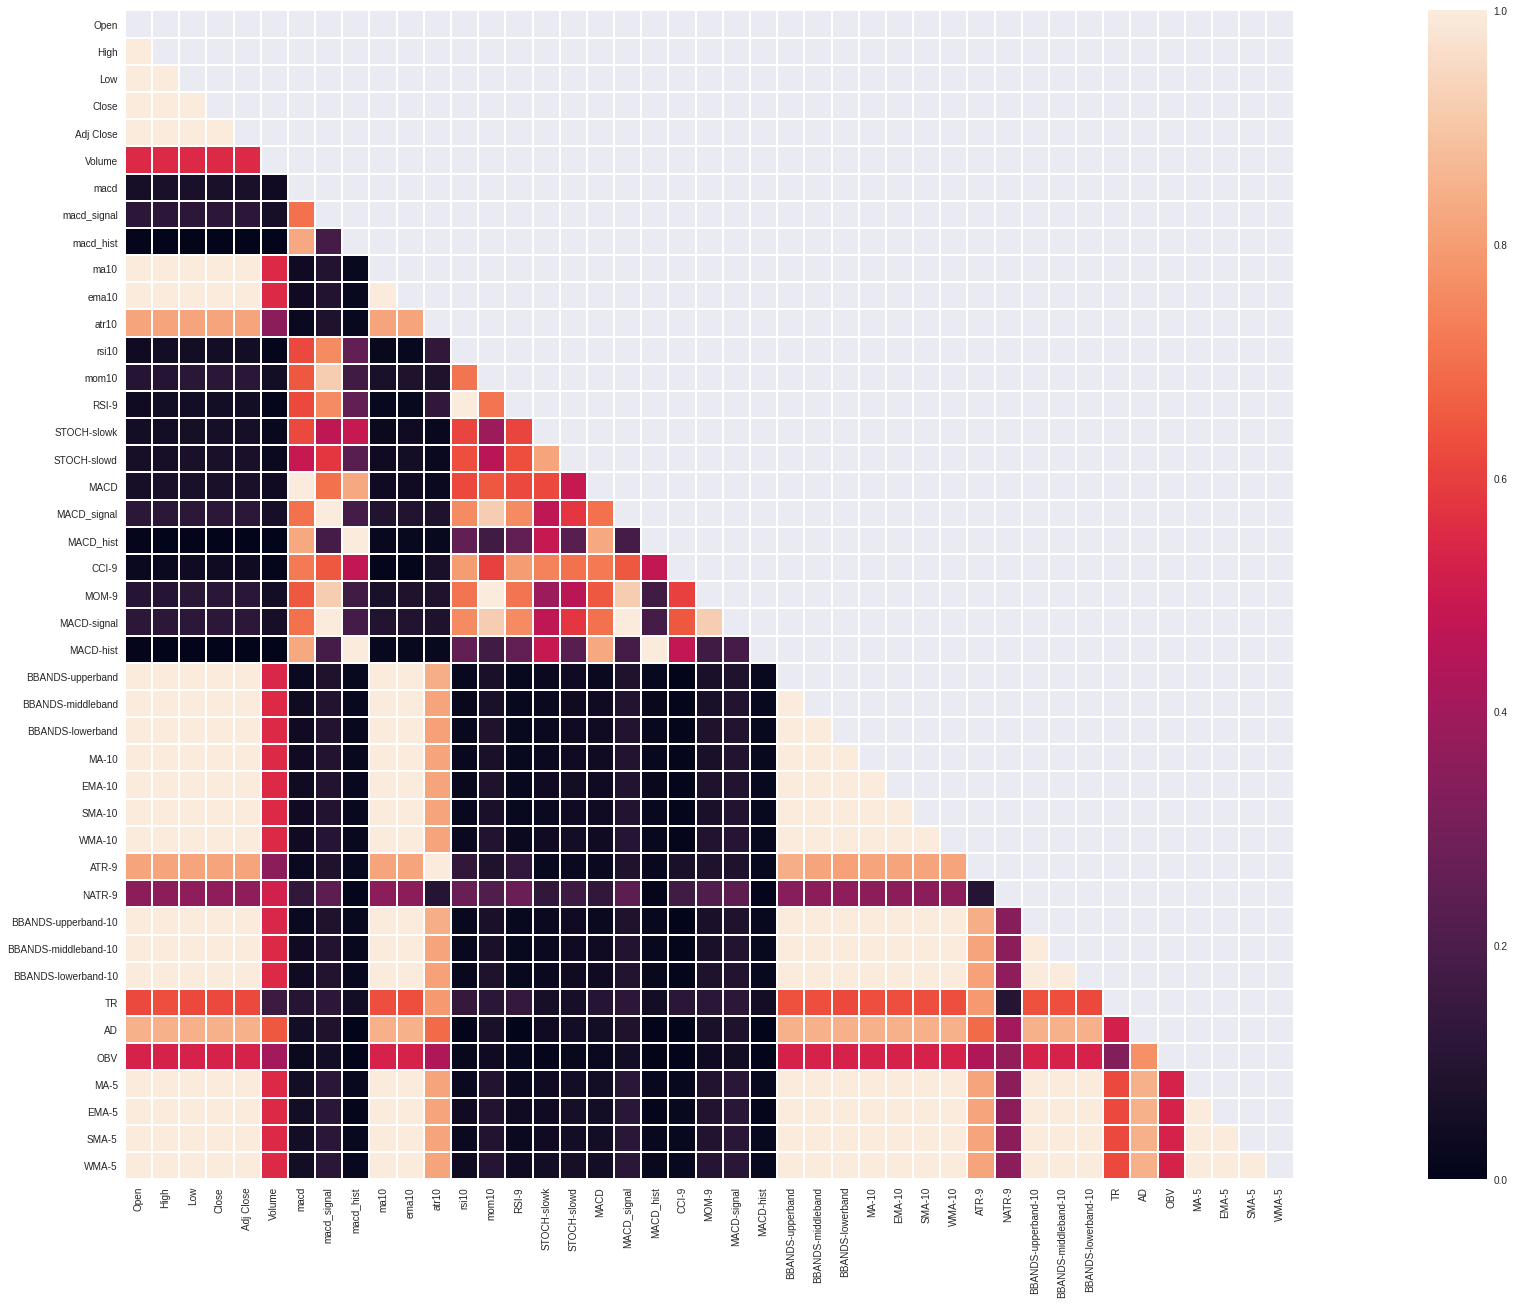

In [ ]:
#
feature_names = X.columns
feat_num = len(feature_names)

plt.figure(figsize=(feat_num,feat_num/2))
feature_df = X
corrMatrix = feature_df.corr().round(2)
corrMatrix = abs(corrMatrix)
# print(corrMatrix)
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
sn.heatmap(corrMatrix, mask=mask,linewidth=1, square=True)

# plt.tight_layout()
# plt.figure(figsize=(10,1))
plt.show()

In [ ]:
df_feature = corrMatrix[['Close']]
df_feature = df_feature[df_feature.Close > 0.6]
print(df_feature)
print(df_feature.index)

                      Close
Open                   1.00
High                   1.00
Low                    1.00
Close                  1.00
Adj Close              1.00
ma10                   1.00
ema10                  1.00
atr10                  0.82
BBANDS-upperband       1.00
BBANDS-middleband      1.00
BBANDS-lowerband       1.00
MA-10                  1.00
EMA-10                 1.00
SMA-10                 1.00
WMA-10                 1.00
ATR-9                  0.82
BBANDS-upperband-10    1.00
BBANDS-middleband-10   1.00
BBANDS-lowerband-10    1.00
TR                     0.62
AD                     0.85
MA-5                   1.00
EMA-5                  1.00
SMA-5                  1.00
WMA-5                  1.00
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'ma10', 'ema10', 'atr10',
       'BBANDS-upperband', 'BBANDS-middleband', 'BBANDS-lowerband', 'MA-10',
       'EMA-10', 'SMA-10', 'WMA-10', 'ATR-9', 'BBANDS-upperband-10',
       'BBANDS-middleband-10', 'BBANDS-lowerband

#Part II: Pipeline Formation (considerations)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 60)                14880     
_________________________________________________________________
Output (Dense)               (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
40/40 [==============================] - 3s 49ms/step - loss: 6.5000e-04 - val_loss: 0.0070

Epoch 00001: val_loss improved from inf to 0.00702, saving model to results/lstm_time_series/model.h5
Epoch 2/100
40/40 [==============================] - 2s 43ms/step - loss: 8.9415e-04 - val_loss: 0.0027

Epoch 00002: val_loss improved from 0.00702 to 0.00267, saving model to results/lstm_time_series/model.h5
Epoch 3/100
40/40 [==============================] - 2s 43ms/step - loss: 8.2492e-04 - v

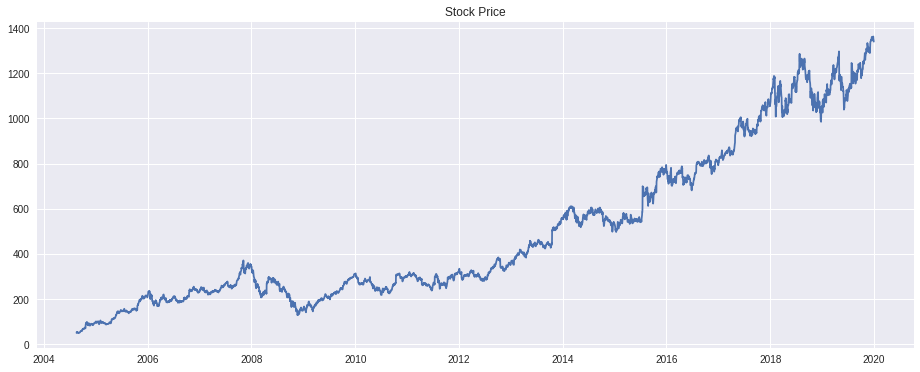

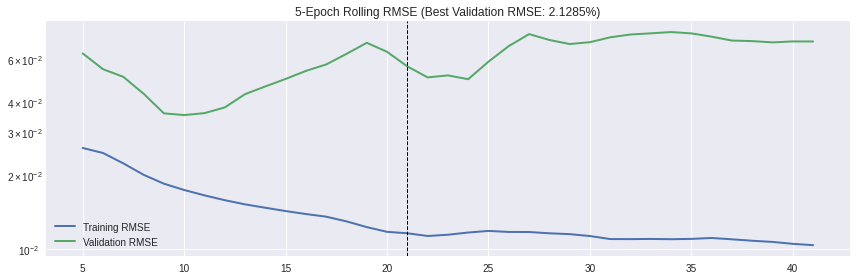

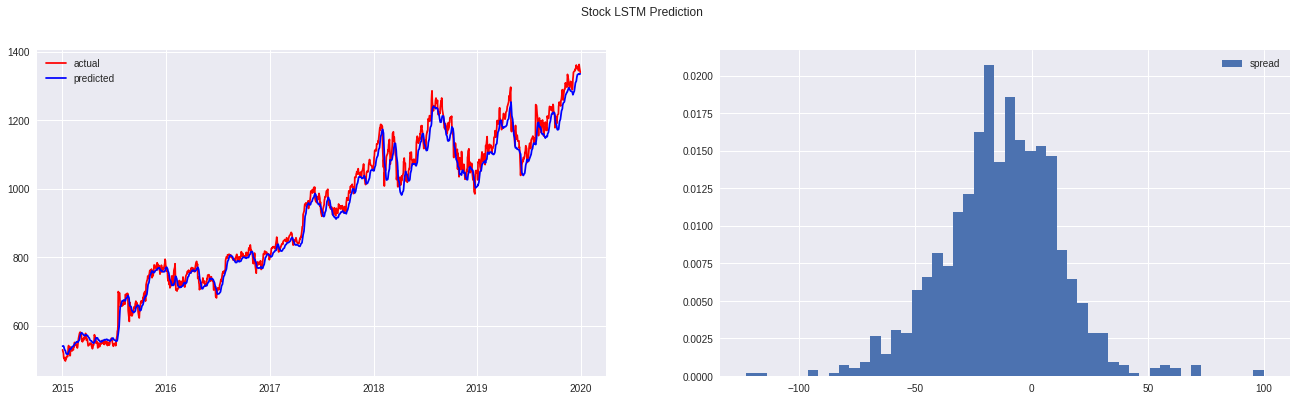

In [ ]:
feature_names = df_feature.index.values
X = X[feature_names]

plt.figure(figsize=(14,6))
plt.title('Stock Price')
plt.plot(y);

scaler = MinMaxScaler()
# scaler = RobustScaler()
data_scaled = pd.Series(scaler.fit_transform(y).squeeze(), index=y.index)

def generate_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 60
X, y = generate_data(data_scaled, window_size=window_size)


# split the data before and after 2015
X_train = X[:'2015-01-01'].values.reshape(-1, window_size, 1)
y_train = y[:'2015-01-01']

# keep the last five year for testing
X_test = X['2015-01-01':].values.reshape(-1, window_size, 1)
y_test = y['2015-01-01':]

batch, timesteps, features = X_train.shape

# complie model five
model = Sequential()
model.add(LSTM(units=X.shape[1], input_shape=(timesteps, features), activation = 'relu', name='LSTM'))
model.add(Dense(units=1, name='Output'))
# model.compile(optimizer='adam', loss='mse')
print(model.summary())
# specify optimizer separately (preferred method)
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='mean_squared_error')

model_path = (results_path / 'model.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=20,
                              restore_best_weights=True)

lstm_training = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    epochs=100,
                    verbose=1,
                    callbacks=[early_stopping, checkpointer],
                    validation_data=(X_test, y_test), shuffle=False)

fig, ax = plt.subplots(figsize=(12, 4))

# derive rmse for the training/validation loss
loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1

# get the best rmse and iteration of the same
best_rmse = loss_history.val_loss.min()
best_epoch = loss_history.val_loss.idxmin()

# plot rolling 5-iteration rmse
loss_history.columns=['Training RMSE', 'Validation RMSE']
title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

# location of best iteration
ax.axvline(best_epoch, ls='--', lw=1, c='k')

# save figure
fig.tight_layout()
fig.savefig(results_path / 'lstm_error', dpi=300);

train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))

print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

# predictions
y_pred = model.predict(X_test)
y_pred = pd.Series(scaler.inverse_transform(y_pred).squeeze(), index=y_test.index)

# rescale y
y_test_rescaled = pd.Series(scaler.inverse_transform(y_test.to_frame()).squeeze(), index = y_test.index)
print(f'R-square: {r2_score(y_test_rescaled, y_pred):0.4}')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(y_test_rescaled, color='red', label='actual')
ax[0].plot(y_pred, color='blue', label='predicted')
ax[1].hist(y_pred - y_test_rescaled, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('Stock LSTM Prediction');


